# From detected synch cues, produce restamped raw Equivital and fixed intervals on march 7th, Thursday

In [14]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [16]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al
%aimport eq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%reload_ext autoreload

In [7]:
# timing of events for 2024-03-07
df_timings = pd.DataFrame(columns=['Event','Event_Type','SS_sTime','SS_dTime'])
Event_data = {'Event':'','Event_Type':'','SS_sTime':0,'SS_dTime':pd.to_timedelta('nan')}
sync_start = (pd.to_datetime('2024-03-07 06:57:50.609+0000')-pd.to_timedelta(21.609342,unit='s')).tz_localize(None)

In [8]:
# 19059.7765
i=0
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_Start'
event_dets['SS_sTime']= 21.609342
event_dets['SS_dTime']= pd.to_datetime('2024-03-07 06:57:50.609+0000').tz_localize(None)
df_timings.loc[i,:]=event_dets

i=1
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_End'
event_dets['SS_sTime']= 21.609342+19059.7765
event_dets['SS_dTime']= pd.to_datetime('2024-03-07 12:15:30.387+0000').tz_localize(None) 
df_timings.loc[i,:]=event_dets

i=2
event_dets = Event_data.copy()
event_dets['Event']='C3'
event_dets['Event_Type']='Concert_Start'
event_dets['SS_sTime']= 5848.517
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

i=3
event_dets = Event_data.copy()
event_dets['Event']='C3'
event_dets['Event_Type']='Concert_End'
event_dets['SS_sTime']= 9004.584
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

i=4
event_dets = Event_data.copy()
event_dets['Event']='C4'
event_dets['Event_Type']='Concert_Start'
event_dets['SS_sTime']= 11868.504
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

i=5
event_dets = Event_data.copy()
event_dets['Event']='C4'
event_dets['Event_Type']='Concert_End'
event_dets['SS_sTime']= 12170.971 + 2813.550
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

i=6
event_dets = Event_data.copy()
event_dets['Event']='WTOrate2'
event_dets['Event_Type']='Rating_Start'
event_dets['SS_sTime']= 12170.971 + 3310.951 # TODO CHECK WHY THIS TIME?
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

i=7
event_dets = Event_data.copy()
event_dets['Event']='WTOrate2'
event_dets['Event_Type']='Rating_End'
event_dets['SS_sTime']= 12170.971 + 3715.706
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets
df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,21.609342,2024-03-07 06:57:50.609000
1,Sync,Sync_End,19081.385842,2024-03-07 12:15:30.387000
2,C3,Concert_Start,5848.517,2024-03-07 08:34:57.516658
3,C3,Concert_End,9004.584,2024-03-07 09:27:33.583658
4,C4,Concert_Start,11868.504,2024-03-07 10:15:17.503658
5,C4,Concert_End,14984.521,2024-03-07 11:07:13.520658
6,WTOrate2,Rating_Start,15481.922,2024-03-07 11:15:30.921658
7,WTOrate2,Rating_End,15886.677,2024-03-07 11:22:15.676658


In [9]:
12170.971 + 3723.639- (11868.504 + 3311.995 )

714.1110000000008

In [10]:
for ev in ['C3','C4','WTOrate2']:
    df_t = df_timings.query('Event == @ev').reset_index(drop = True)
    print(df_t)

  Event     Event_Type  SS_sTime                    SS_dTime
0    C3  Concert_Start  5848.517  2024-03-07 08:34:57.516658
1    C3    Concert_End  9004.584  2024-03-07 09:27:33.583658
  Event     Event_Type   SS_sTime                    SS_dTime
0    C4  Concert_Start  11868.504  2024-03-07 10:15:17.503658
1    C4    Concert_End  14984.521  2024-03-07 11:07:13.520658
      Event    Event_Type   SS_sTime                    SS_dTime
0  WTOrate2  Rating_Start  15481.922  2024-03-07 11:15:30.921658
1  WTOrate2    Rating_End  15886.677  2024-03-07 11:22:15.676658


In [11]:
df_shifts=pd.read_csv('./outfiles/Cue_dev_align_20240307.csv', index_col=0)
df_shifts['Cue1_devdTime'] = pd.to_datetime(df_shifts['Cue1_devdTime']).dt.tz_localize(None)
df_shifts['Cue2_devdTime'] = pd.to_datetime(df_shifts['Cue2_devdTime']).dt.tz_localize(None)
df_shifts['dur_dt'] = pd.to_timedelta(df_shifts['dur_dt'])
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
VN101,2024-03-07 06:57:48.714811154,1.894531,0.771807,2024-03-07 12:15:25.660879904,4.726562,0.708769,0 days 05:17:36.946068750,19056.946069,-2.832005,-0.534908,3420415,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN104,2024-03-07 06:57:51.273404904,-0.664062,0.720048,2024-03-07 12:15:28.422598654,1.964844,0.730254,0 days 05:17:37.149193750,19057.149194,-2.628880,-0.496541,3420456,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN109,2024-03-07 06:57:50.171842404,0.437500,0.662459,2024-03-07 12:15:28.379629904,2.007812,0.639071,0 days 05:17:38.207787500,19058.207787,-1.570287,-0.296595,5022010,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN105,2024-03-07 06:57:49.367154904,1.242188,0.612933,2024-03-07 12:15:26.582754904,3.804688,0.595153,0 days 05:17:37.215600,19057.215600,-2.562474,-0.483999,3420755,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN111,2024-03-07 06:57:50.624967404,-0.015625,0.644069,2024-03-07 12:15:29.094473654,1.292969,0.611731,0 days 05:17:38.469506250,19058.469506,-1.308568,-0.247162,5022027,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN110,2024-03-07 06:57:51.996061154,-1.386719,0.626103,2024-03-07 12:15:30.481192404,-0.093750,0.690122,0 days 05:17:38.485131250,19058.485131,-1.292943,-0.244210,5022026,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN201,2024-03-07 06:57:49.921842404,0.687500,0.664385,2024-03-07 12:15:28.426504904,1.960938,0.671248,0 days 05:17:38.504662500,19058.504662,-1.273412,-0.240521,5022050,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN206,2024-03-07 06:57:50.605436154,0.003906,0.765091,2024-03-07 12:15:28.836661154,1.550781,0.748492,0 days 05:17:38.231225,19058.231225,-1.546849,-0.292168,5022062,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234
VN211,2024-03-07 06:57:50.187467404,0.421875,0.659537,2024-03-07 12:15:28.664786154,1.722656,0.692505,0 days 05:17:38.477318750,19058.477319,-1.300755,-0.245686,5022247,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234


In [83]:
# data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
data_dir='/Volumes/SeagateHub/BiC2024/20240307/Equivital/Extracted SEM Data/'

sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
VN101,DATA,3420415,240307,0,DATA-VN101-3420415-24030700.CSV,csv,113066,2024-03-07 06:49:41+00:00,2024-03-07 12:20:56+00:00,19875.0,...,[VN101],3420415.0,VN101,53.0,0,98.0,0.0,0.0,MovingSlowly,Upright
VN104,DATA,3420456,240307,101,DATA-VN104-3420456-24030700_0.CSV,csv,112528,2024-03-07 06:49:43+00:00,2024-03-07 12:22:43+00:00,19980.0,...,[VN104],3420456.0,VN104,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN109,DATA,5022010,240307,101,DATA-VN109-5022010-24030700_0.CSV,csv,112208,2024-03-07 06:49:45+00:00,2024-03-07 12:21:15+00:00,19890.0,...,[VN109],5022010.0,VN109,53.0,79,98.0,0.0,0.0,Stationary,Upright
VN105,DATA,3420755,240307,101,DATA-VN105-3420755-24030700_0.CSV,csv,111795,2024-03-07 06:49:45+00:00,2024-03-07 12:21:15+00:00,19890.0,...,[VN105],3420755.0,VN105,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN111,DATA,5022027,240307,0,DATA-VN111-5022027-24030700.CSV,csv,112517,2024-03-07 06:49:49+00:00,2024-03-07 12:22:04+00:00,19935.0,...,[VN111],5022027.0,VN111,53.0,2,97.0,0.0,0.0,Stationary,Upright


# Test Realign and cut

In [43]:
pid = 'VN105'
dets = df_datafiles.loc[pid,:]
dets

Signal                                                            DATA
ID                                                             3420755
Date                                                            240307
Session                                                            101
FileName                             DATA-VN105-3420755-24030700_0.CSV
FileType                                                           csv
FileSize                                                        111795
RecStart                                     2024-03-07 06:49:45+00:00
RecEnd                                       2024-03-07 12:21:15+00:00
Duration                                                       19890.0
BatteryStart                                                      4141
BatteryEnd                                                        4023
BatteryChange(mV)                                                 -118
FullLoc              /Volumes/TaeTae/Stavangar/20240307/Extracted S...
DATAlo

In [44]:
df_shifts.loc[pid,:]

Cue1_devdTime      2024-03-07 06:57:49.367154904
Cue1_s                                  1.242188
Cue1_r                                  0.612933
Cue2_devdTime      2024-03-07 12:15:26.582754904
Cue2_s                                  3.804688
Cue2_r                                  0.595153
dur_dt                    0 days 05:17:37.215600
dur_s                                 19057.2156
drift_s                                  -2.5609
drift_rate_sphr                        -0.483701
Name: VN105, dtype: object

In [45]:
df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,21.609342,2024-03-07 06:57:50.609000
1,Sync,Sync_End,19081.385842,2024-03-07 12:15:30.387000
2,C3,Concert_Start,5848.517,2024-03-07 08:34:57.517000
3,C3,Concert_End,9004.584,2024-03-07 09:27:33.584000
4,C4,Concert_Start,11868.504,2024-03-07 10:15:17.504000
5,C4,Concert_End,14984.521,2024-03-07 11:07:13.521000
6,WTOrate2,Rating_Start,15180.499,2024-03-07 11:10:29.499000
7,WTOrate2,Rating_End,15894.61,2024-03-07 11:22:23.610000


In [46]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
V

,DateTime,Vert Accelerometer,Lat Accelerometer,Long Accelerometer
0,2024-03-07 06:49:17.007+00:00,0,0,0
1,2024-03-07 06:49:17.011+00:00,0,0,0
2,2024-03-07 06:49:17.015+00:00,0,0,0
3,2024-03-07 06:49:17.019+00:00,0,0,0
4,2024-03-07 06:49:17.023+00:00,0,0,0
...,...,...,...,...
5101474,2024-03-07 12:21:24.613+00:00,-20,-74,-979
5101475,2024-03-07 12:21:24.617+00:00,-16,-59,-971
5101476,2024-03-07 12:21:24.621+00:00,-23,-82,-971
5101477,2024-03-07 12:21:24.624+00:00,-16,-70,-971


In [47]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df


In [48]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_localize(None)
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

#ACC = remove_tz_from_dataframe(ACC)
ACC.iloc[:5,:]

,dev_dTime,X,Y,Z,signal
0,2024-03-07 06:49:17.007,0,0,0,0.0
1,2024-03-07 06:49:17.011,0,0,0,0.0
2,2024-03-07 06:49:17.015,0,0,0,0.0
3,2024-03-07 06:49:17.019,0,0,0,0.0
4,2024-03-07 06:49:17.023,0,0,0,0.0


In [49]:
sync1_s = 0
sync1_dt = df_timings.loc[0,'SS_dTime']
sync2_s = df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime']
sync2_dt = df_timings.loc[1,'SS_dTime']

In [50]:
df_shifts.loc[pid,:]

Cue1_devdTime      2024-03-07 06:57:49.367154904
Cue1_s                                  1.242188
Cue1_r                                  0.612933
Cue2_devdTime      2024-03-07 12:15:26.582754904
Cue2_s                                  3.804688
Cue2_r                                  0.595153
dur_dt                    0 days 05:17:37.215600
dur_s                                 19057.2156
drift_s                                  -2.5609
drift_rate_sphr                        -0.483701
Name: VN105, dtype: object

In [51]:
drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
drift_C

1.000134379547031

In [52]:
drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()

ACC['rTime_s'] =np.round((ACC['dev_dTime']-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,3)+df_timings.loc[0,'SS_sTime']
#  df_timings.loc[0,'SS_sTime'] + 
ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
ACC.iloc[:5,:]

,dev_dTime,X,Y,Z,signal,rTime_s,rTime_dt
0,2024-03-07 06:49:17.007,0,0,0,0.0,-490.819658,2024-03-07 06:49:18.180
1,2024-03-07 06:49:17.011,0,0,0,0.0,-490.815658,2024-03-07 06:49:18.184
2,2024-03-07 06:49:17.015,0,0,0,0.0,-490.811658,2024-03-07 06:49:18.188
3,2024-03-07 06:49:17.019,0,0,0,0.0,-490.807658,2024-03-07 06:49:18.192
4,2024-03-07 06:49:17.023,0,0,0,0.0,-490.803658,2024-03-07 06:49:18.196


In [42]:
ACC1 = ACC.copy()

Test out put: are these two signals aligned in rTime_s, in rTime_dt?

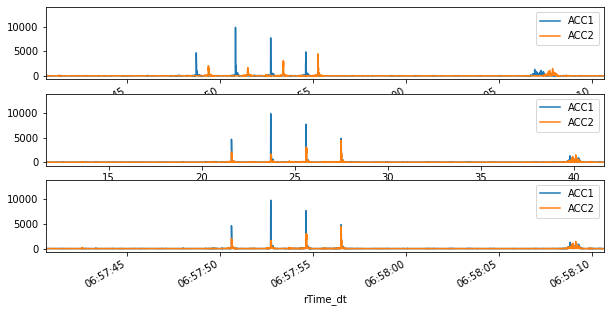

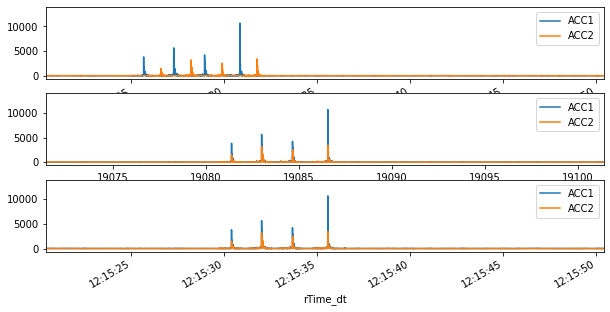

In [56]:
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[0,'SS_sTime']-10,df_timings.loc[0,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[0,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[0,'SS_dTime']+pd.to_timedelta(20,unit='s')])

plt.show()
    
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[1,'SS_sTime']-10,df_timings.loc[1,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[1,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[1,'SS_dTime']+pd.to_timedelta(20,unit='s')])

plt.show()
     

# Output full and for each event


In [86]:
CUTLOGS = pd.concat([df_datafiles,df_shifts,CUTLOGS],axis=1)
CUTS= pd.Series()
CUTS[pid] = []
#['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']
# newdata_dir='/Volumes/TaeTae/Stavangar/20240307/'
# data_dir='/Volumes/SeagateHub/BiC2024/Equivital/Extracted SEM Data/'
newdata_dir='/Volumes/SeagateHub/BiC2024_Synced/Equivital/'

sig_map = {'DATAloc':'EQDATA','ACCloc':'EQBACC','RESPloc':'EQRESP','RRloc':'EQCIBI','ECGloc':'EQ2ECG'}
cut_ind = 0
toc = time.time()
rec_day = '20240307'
buff = pd.to_timedelta(15,unit='s') # 2 minute buffer on cutes for concert and stuff pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s')
segmentid = 'FULL'

for pid in CUTLOGS.index:
    tic = time.time()
    outfiles = []
    tic = time.time()
    drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
    eqfiles = df_datafiles.loc[pid,['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']]
    for f in eqfiles.index:
        SignalID = sig_map[f]
        V = pd.read_csv(eqfiles[f],skipinitialspace=True)
        dt_col = V.columns[0] # assume first column is time, specifically datetime
        sig_col = V.columns[1:]
        V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_localize(None) # .dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')

        V['rTime_s'] =np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        V['rTime_dt'] = pd.to_timedelta(V['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig = pd.DataFrame()
        RecTimeSig['rec_sTime'] = np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig['dev_dTime'] = V[dt_col]
        RecTimeSig.loc[:,sig_col] = V[sig_col]
        
        seg_filename = '_'.join([pid,rec_day,'FULL',SignalID+'.csv'])
        new_col_order=['rec_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        RecTimeSig[new_col_order].to_csv(newdata_dir + 'FullDay/'+ rec_day+ '/'+ seg_filename, index = False)

        new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        # run through events in that section
        for ev in ['C3','C4','WTOrate2']:
            df_t = df_timings.query('Event == @ev').reset_index(drop = True)
            subsig  = al.dt_cut(RecTimeSig,'rec_dTime',df_t.loc[0,'SS_dTime']-buff,df_t.loc[1,'SS_dTime']+buff)
            subsig['c_sTime'] = np.round((subsig['rec_dTime']-df_t.loc[0,'SS_dTime']).dt.total_seconds(),4)
            #C1_FULL_BR601_EQBACC 
            seg_filename = '_'.join([ev,segmentid,pid,SignalID+'.csv'])
            outfiles.append(seg_filename)
            subsig[new_col_order].to_csv(newdata_dir + ev+'/' + seg_filename, index = False)
           
        print(' '.join([pid,SignalID ,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))


CUTS= pd.Series()
CUTS[pid] = []
CUTLOGS['Output_files']=CUTS
CUTLOGS.to_csv('./outfiles/'+rec_day+'EQIVITALS_CUTLOGS.csv')
# CUTLOGS['Scaling_C'].hist()
# plt.show()
CUTLOGS

VN101 EQDATA 0.204 0.205
VN101 EQBACC 61.361 61.362
VN101 EQRESP 67.098 67.099
VN101 EQCIBI 67.393 67.394
VN101 EQ2ECG 131.927 131.928
VN104 EQDATA 0.151 132.079
VN104 EQBACC 60.334 192.262
VN104 EQRESP 66.142 198.07
VN104 EQCIBI 66.436 198.364
VN104 EQ2ECG 130.441 262.369
VN109 EQDATA 0.138 262.508
VN109 EQBACC 60.103 322.473
VN109 EQRESP 66.134 328.504
VN109 EQCIBI 66.614 328.984
VN109 EQ2ECG 133.032 395.401
VN105 EQDATA 0.137 395.538
VN105 EQBACC 63.148 458.55
VN105 EQRESP 69.249 464.651
VN105 EQCIBI 69.53 464.932
VN105 EQ2ECG 137.692 533.094
VN111 EQDATA 0.148 533.242
VN111 EQBACC 66.22 599.314
VN111 EQRESP 72.807 605.902
VN111 EQCIBI 73.3 606.395
VN111 EQ2ECG 140.43 673.525
VN110 EQDATA 0.157 673.682
VN110 EQBACC 64.094 737.619
VN110 EQRESP 70.257 743.782
VN110 EQCIBI 70.724 744.249
VN110 EQ2ECG 138.607 812.132
VN201 EQDATA 0.152 812.284
VN201 EQBACC 64.074 876.206
VN201 EQRESP 69.989 882.122
VN201 EQCIBI 70.35 882.482
VN201 EQ2ECG 136.738 948.87
VN206 EQDATA 0.145 949.015
VN206 E

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,Output_files
VN101,DATA,3420415,240307,0,DATA-VN101-3420415-24030700.CSV,csv,113066,2024-03-07 06:49:41+00:00,2024-03-07 12:20:56+00:00,19875.0,...,1.894531,0.771807,2024-03-07 12:15:25.660879904,4.726562,0.708769,0 days 05:17:36.946068750,19056.946069,-2.830431,-0.534610,NaN
VN104,DATA,3420456,240307,101,DATA-VN104-3420456-24030700_0.CSV,csv,112528,2024-03-07 06:49:43+00:00,2024-03-07 12:22:43+00:00,19980.0,...,-0.664062,0.720048,2024-03-07 12:15:28.422598654,1.964844,0.730254,0 days 05:17:37.149193750,19057.149194,-2.627306,-0.496244,NaN
VN109,DATA,5022010,240307,101,DATA-VN109-5022010-24030700_0.CSV,csv,112208,2024-03-07 06:49:45+00:00,2024-03-07 12:21:15+00:00,19890.0,...,0.437500,0.662459,2024-03-07 12:15:28.379629904,2.007812,0.639071,0 days 05:17:38.207787500,19058.207787,-1.568713,-0.296298,NaN
VN105,DATA,3420755,240307,101,DATA-VN105-3420755-24030700_0.CSV,csv,111795,2024-03-07 06:49:45+00:00,2024-03-07 12:21:15+00:00,19890.0,...,1.242188,0.612933,2024-03-07 12:15:26.582754904,3.804688,0.595153,0 days 05:17:37.215600,19057.215600,-2.560900,-0.483701,NaN
VN111,DATA,5022027,240307,0,DATA-VN111-5022027-24030700.CSV,csv,112517,2024-03-07 06:49:49+00:00,2024-03-07 12:22:04+00:00,19935.0,...,-0.015625,0.644069,2024-03-07 12:15:29.094473654,1.292969,0.611731,0 days 05:17:38.469506250,19058.469506,-1.306994,-0.246864,NaN
VN110,DATA,5022026,240307,101,DATA-VN110-5022026-24030700_0.CSV,csv,112858,2024-03-07 06:49:51+00:00,2024-03-07 12:22:36+00:00,19965.0,...,-1.386719,0.626103,2024-03-07 12:15:30.481192404,-0.093750,0.690122,0 days 05:17:38.485131250,19058.485131,-1.291369,-0.243913,NaN
VN201,DATA,5022050,240307,0,DATA-VN201-5022050-24030700.CSV,csv,111862,2024-03-07 06:50:45+00:00,2024-03-07 12:21:00+00:00,19815.0,...,0.687500,0.664385,2024-03-07 12:15:28.426504904,1.960938,0.671248,0 days 05:17:38.504662500,19058.504662,-1.271838,-0.240224,NaN
VN206,DATA,5022062,240307,0,DATA-VN206-5022062-24030700.CSV,csv,111867,2024-03-07 06:50:48+00:00,2024-03-07 12:21:03+00:00,19815.0,...,0.003906,0.765091,2024-03-07 12:15:28.836661154,1.550781,0.748492,0 days 05:17:38.231225,19058.231225,-1.545275,-0.291871,NaN
VN211,DATA,5022247,240307,0,DATA-VN211-5022247-24030700.CSV,csv,112083,2024-03-07 06:50:50+00:00,2024-03-07 12:22:05+00:00,19875.0,...,0.421875,0.659537,2024-03-07 12:15:28.664786154,1.722656,0.692505,0 days 05:17:38.477318750,19058.477319,-1.299181,-0.245389,NaN
VN212,DATA,5022256,240307,0,DATA-VN212-5022256-24030700.CSV,csv,112112,2024-03-07 06:50:53+00:00,2024-03-07 12:21:38+00:00,19845.0,...,-0.429688,0.733429,2024-03-07 12:15:29.360098654,1.027344,0.762272,0 days 05:17:38.321068750,19058.321069,-1.455431,-0.274901,NaN


In [12]:
# 4099.328 for all segments

# Fix Rating task time 
there was an error in the initial cut of the rating tasks from equivitals. This has been double checked and is cutting to the stimulus audio range, now that that has been fixed. 

In [18]:
concert = '20240307'
data_dir='/Volumes/SeagateHub/BiC2024_Synced/Equivital/FullDay/'
sep = '/'
DATAtag='EQDATA'
df_datafiles = eq.eq_recordings(data_dir+concert+'/','EQDATA','/')
df_datafiles.set_index('PartID',inplace=True)
df_datafiles

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,EventStart,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
PartID,,,,,,,,,,,,,,,,,,,,,
VN104,DATA,[3420456],2024-03-07,20240307,VN104_20240307_FULL_EQDATA.csv,csv,160134,2024-03-07 06:49:42.268300,2024-03-07 12:22:45.022800,0,...,[VN104],3420456.0,VN104,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN101,DATA,[3420415],2024-03-07,20240307,VN101_20240307_FULL_EQDATA.csv,csv,160423,2024-03-07 06:49:42.821800,2024-03-07 12:21:00.773700,0,...,[VN101],3420415.0,VN101,53.0,0,98.0,0.0,0.0,MovingSlowly,Upright
VN109,DATA,[5022010],2024-03-07,20240307,VN109_20240307_FULL_EQDATA.csv,csv,159700,2024-03-07 06:49:45.397200,2024-03-07 12:21:17.034400,0,...,[VN109],5022010.0,VN109,53.0,79,98.0,0.0,0.0,Stationary,Upright
VN105,DATA,[3420755],2024-03-07,20240307,VN105_20240307_FULL_EQDATA.csv,csv,159275,2024-03-07 06:49:46.176800,2024-03-07 12:21:18.849600,0,...,[VN105],3420755.0,VN105,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN111,DATA,[5022027],2024-03-07,20240307,VN111_20240307_FULL_EQDATA.csv,csv,160394,2024-03-07 06:49:48.951000,2024-03-07 12:22:05.318100,0,...,[VN111],5022027.0,VN111,53.0,2,97.0,0.0,0.0,Stationary,Upright
VN110,DATA,[5022026],2024-03-07,20240307,VN110_20240307_FULL_EQDATA.csv,csv,160499,2024-03-07 06:49:49.580300,2024-03-07 12:22:35.933100,0,...,[VN110],5022026.0,VN110,53.0,84,98.0,0.0,0.0,Stationary,Upright
VN201,DATA,[5022050],2024-03-07,20240307,VN201_20240307_FULL_EQDATA.csv,csv,159177,2024-03-07 06:50:45.658800,2024-03-07 12:21:01.981100,0,...,[VN201],5022050.0,VN201,53.0,71,98.0,0.0,0.0,Stationary,Upright
VN206,DATA,[5022062],2024-03-07,20240307,VN206_20240307_FULL_EQDATA.csv,csv,159187,2024-03-07 06:50:47.969300,2024-03-07 12:21:04.575900,0,...,[VN206],5022062.0,VN206,53.0,66,99.0,0.0,0.0,Stationary,Upright
VN211,DATA,[5022247],2024-03-07,20240307,VN211_20240307_FULL_EQDATA.csv,csv,159510,2024-03-07 06:50:50.392900,2024-03-07 12:22:06.747700,0,...,[VN211],5022247.0,VN211,53.0,79,97.0,0.0,0.0,Stationary,Upright


In [20]:
CUTLOGS = pd.concat([df_datafiles,df_shifts],axis=1)#,CUTLOGS
CUTS= pd.Series()
# newdata_dir='/Volumes/SeagateHub/BiC2024_Synced/Equivital/'
newdata_dir='/Volumes/TaeTae/Stavangar/bic2024/'
sig_map = {'DATAloc':'EQDATA','BACCloc':'EQBACC','RESPloc':'EQRESP','CIBIloc':'EQCIBI','2ECGloc':'EQ2ECG'}
cut_ind = 0
toc = time.time()
rec_day = '20240307'
buff = pd.to_timedelta(15,unit='s') # 2 minute buffer on cutes for concert and stuff pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s')
segmentid = 'FULL'

for pid in CUTLOGS.index:
    tic = time.time()
    outfiles = []
    tic = time.time()
#     drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
    eqfiles = df_datafiles.loc[pid,['DATAloc','BACCloc','RESPloc','CIBIloc','2ECGloc']]
    for f in eqfiles.index:
        SignalID = sig_map[f]
        RecTimeSig = pd.read_csv(eqfiles[f],skipinitialspace=True)
        RecTimeSig['rec_dTime']=pd.to_datetime(RecTimeSig['rec_dTime'])
        sig_col = RecTimeSig.columns
        new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        
        # run through events in that section
        for ev in ['WTOrate2']:#['C1','C2','WTOrate1']:
            df_t = df_timings.query('Event == @ev').reset_index(drop = True)
            subsig  = al.dt_cut(RecTimeSig,'rec_dTime',df_t.loc[0,'SS_dTime']-buff,df_t.loc[1,'SS_dTime']+buff)
            subsig['c_sTime'] = np.round((subsig['rec_dTime']-df_t.loc[0,'SS_dTime']).dt.total_seconds(),4)
            #C1_FULL_BR601_EQBACC 
            seg_filename = '_'.join([ev,segmentid,pid,SignalID+'.csv'])
            outfiles.append(seg_filename)
            subsig[new_col_order].to_csv(newdata_dir + ev+'/' + seg_filename, index = False)
           
        print(' '.join([pid,SignalID ,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))


CUTS= pd.Series()
CUTS[pid] = []
CUTLOGS['Output_files']=CUTS
CUTLOGS.to_csv('./outfiles/'+rec_day+'EQIVITALS_CUTLOGS.csv')
# CUTLOGS['Scaling_C'].hist()
# plt.show()
CUTLOGS

VN104 EQDATA 0.605 0.606
VN104 EQBACC 11.089 11.089
VN104 EQRESP 12.536 12.537
VN104 EQCIBI 12.642 12.643
VN104 EQ2ECG 25.344 25.344
VN101 EQDATA 0.229 25.574
VN101 EQBACC 12.064 37.409
VN101 EQRESP 13.461 38.805
VN101 EQCIBI 13.561 38.906
VN101 EQ2ECG 24.723 50.067
VN109 EQDATA 0.241 50.309
VN109 EQBACC 10.555 60.623
VN109 EQRESP 11.985 62.053
VN109 EQCIBI 12.114 62.182
VN109 EQ2ECG 22.72 72.788
VN105 EQDATA 0.27 73.058
VN105 EQBACC 11.135 83.923
VN105 EQRESP 12.804 85.592
VN105 EQCIBI 12.9 85.688
VN105 EQ2ECG 23.699 96.487
VN111 EQDATA 0.238 96.726
VN111 EQBACC 11.202 107.689
VN111 EQRESP 12.94 109.428
VN111 EQCIBI 13.052 109.539
VN111 EQ2ECG 23.501 119.989
VN110 EQDATA 0.262 120.251
VN110 EQBACC 11.137 131.126
VN110 EQRESP 12.324 132.312
VN110 EQCIBI 12.478 132.467
VN110 EQ2ECG 22.694 142.683
VN201 EQDATA 0.235 142.918
VN201 EQBACC 10.826 153.509
VN201 EQRESP 12.132 154.815
VN201 EQCIBI 12.242 154.925
VN201 EQ2ECG 22.967 165.65
VN206 EQDATA 0.246 165.896
VN206 EQBACC 10.471 176.121


,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,EventStart,...,drift_rate_sphr,devID,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt,Output_files
VN104,DATA,[3420456],2024-03-07,20240307,VN104_20240307_FULL_EQDATA.csv,csv,160134,2024-03-07 06:49:42.268300,2024-03-07 12:22:45.022800,0,...,-0.496541,3420456,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN101,DATA,[3420415],2024-03-07,20240307,VN101_20240307_FULL_EQDATA.csv,csv,160423,2024-03-07 06:49:42.821800,2024-03-07 12:21:00.773700,0,...,-0.534908,3420415,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN109,DATA,[5022010],2024-03-07,20240307,VN109_20240307_FULL_EQDATA.csv,csv,159700,2024-03-07 06:49:45.397200,2024-03-07 12:21:17.034400,0,...,-0.296595,5022010,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN105,DATA,[3420755],2024-03-07,20240307,VN105_20240307_FULL_EQDATA.csv,csv,159275,2024-03-07 06:49:46.176800,2024-03-07 12:21:18.849600,0,...,-0.483999,3420755,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN111,DATA,[5022027],2024-03-07,20240307,VN111_20240307_FULL_EQDATA.csv,csv,160394,2024-03-07 06:49:48.951000,2024-03-07 12:22:05.318100,0,...,-0.247162,5022027,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN110,DATA,[5022026],2024-03-07,20240307,VN110_20240307_FULL_EQDATA.csv,csv,160499,2024-03-07 06:49:49.580300,2024-03-07 12:22:35.933100,0,...,-0.244210,5022026,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN201,DATA,[5022050],2024-03-07,20240307,VN201_20240307_FULL_EQDATA.csv,csv,159177,2024-03-07 06:50:45.658800,2024-03-07 12:21:01.981100,0,...,-0.240521,5022050,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN206,DATA,[5022062],2024-03-07,20240307,VN206_20240307_FULL_EQDATA.csv,csv,159187,2024-03-07 06:50:47.969300,2024-03-07 12:21:04.575900,0,...,-0.292168,5022062,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN211,DATA,[5022247],2024-03-07,20240307,VN211_20240307_FULL_EQDATA.csv,csv,159510,2024-03-07 06:50:50.392900,2024-03-07 12:22:06.747700,0,...,-0.245686,5022247,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
VN212,DATA,[5022256],2024-03-07,20240307,VN212_20240307_FULL_EQDATA.csv,csv,159614,2024-03-07 06:50:52.538000,2024-03-07 12:21:39.053600,0,...,-0.275198,5022256,/Volumes/Seagatehub/BiC2024/20240307/Equivital...,./outfiles/cue1_20240307.csv,cue1_20240307,2024-03-07 06:57:50.609342404,./outfiles/cue2_20240307.csv,cue2_20240307,2024-03-07 12:15:30.387417234,NaN
